## Imports

In [1]:
import os
from operator import itemgetter

import gym_donkeycar
import gymnasium as gym
import imageio
import ipywidgets as widgets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from IPython.display import display
from ipywidgets import HBox, VBox
from matplotlib import pyplot as plt
from PIL import Image
from ruamel.yaml import YAML
from tensorboard import notebook
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from torch import distributions as dist
from torch.distributions import Categorical, Normal
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm

# suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["IMAGEIO_IGNORE_WARNINGS"] = "True"

import gym.spaces as gym_spaces
import gymnasium as gym  # overwrite OpenAI gym
import stable_baselines3 as sb3
from gym_donkeycar.envs.donkey_env import DonkeyEnv
from gymnasium import spaces
from gymnasium.spaces import Box
from stable_baselines3 import A2C, PPO, SAC
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv

from src.actor_critic import ContinuousActorCritic
# custom classes and functions
from src.blocks import CategoricalStraightThrough, ConvBlock
from src.categorical_vae import CategoricalVAE
from src.imagination_env import ImaginationEnv
from src.mlp import MLP
from src.preprocessing import grayscale_transform as transform
from src.rssm import RSSM
from src.utils import load_config, save_image_and_reconstruction, to_np

torch.cuda.empty_cache()
%matplotlib inline

## Load the config

In [2]:
config = load_config()

for key in config:
    locals()[key] = config[key]

print(config)

{'device': device(type='cuda', index=0), 'A': 3, 'Z': 1024, 'debug': False, 'logdir': 'logs/', 'seed': 0, 'size': [128, 128], 'grayscale': True, 'toy_env': True, 'n_episodes': 5000, 'max_episode_steps': 500, 'max_imagination_episode_steps': 200, 'imagination_timesteps_per_model_update': 500, 'env_id': 'donkey-minimonaco-track-v0', 'max_grad_norm': 1, 'batch_size': 1, 'H': 512, 'num_categoricals': 32, 'num_classes': 32, 'buffer_size': 10000, 'mlp_n_layers': 3, 'mlp_hidden_dims': 256, 'verbose': 0, 'imagination_progress_bar': False, 'action_clip': 1}


## Create the environment

In [3]:
sim_config = {
    "exe_path" : "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64",
    "port" : 9091
}
env = gym.make(
    "GymV21Environment-v0",
    env_id=env_id,
    max_episode_steps=1000,
    make_kwargs={
        "conf": sim_config
    })

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!


## Create the agent

In [4]:
agent = SAC(
    "CnnPolicy", 
    env,
    buffer_size=20_000,
    verbose=1, 
    tensorboard_log="logs/")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Train the agent

In [ ]:
agent.learn(total_timesteps=30_000)

In [ ]:
# agent = SAC(
#     "CnnPolicy", 
#     env,
#     buffer_size=20_000,
#     verbose=1, 
#     tensorboard_log="logs/")
# 
# eval_callback = EvalCallback(
#     env, 
#     best_model_save_path='weights/', 
#     log_path='logs/', 
#     eval_freq=500,
#     n_eval_episodes=1)
#
# agent.learn(total_timesteps=30_000, callback=eval_callback)

## Plot the results

In [17]:
# files = {
#     "SAC_27": "logs/SAC_27/events.out.tfevents.1684525093.z.31751.0",
# }
# 
# for event_file in os.listdir("logs/A2C_19/"):
#     files["A2C_19"] = "logs/A2C_19/" + event_file

In [21]:
files = {}

In [ ]:
for key, log_file in files.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    steps = []
    rewards = []

    for event in event_acc.Scalars("rollout/ep_rew_mean"):
        steps.append(event.step)
        rewards.append(event.value)

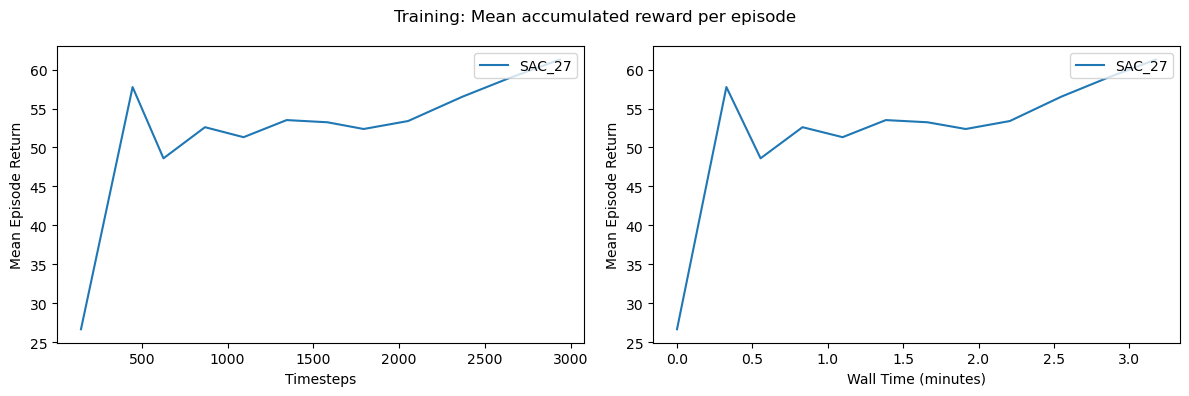

In [22]:
baselines = {
    "SAC_27": "logs/SAC_27/events.out.tfevents.1684525093.z.31751.0",
}

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Training: Mean accumulated reward per episode", fontsize=12)

""" Steps on x-axis plot """

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    steps = []
    rewards = []

    for event in event_acc.Scalars("rollout/ep_rew_mean"):
        steps.append(event.step)
        rewards.append(event.value)
        
    axs[0].plot(steps, rewards, label=key)

axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Mean Episode Return')
axs[0].legend(loc="upper right")

""" wall time on x-axis plot """

for key, log_file in baselines.items():
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()

    wtimes = []
    rewards = []

    for event in event_acc.Scalars("rollout/ep_rew_mean"):
        wtimes.append(event.wall_time)
        rewards.append(event.value)

    # Subtract the first wtime to start at 0 
    # and convert it to minutes
    wtimes = np.array(wtimes) - wtimes[0]
    wtimes /= 60

    axs[1].plot(wtimes, rewards, label=key)

axs[1].set_xlabel('Wall Time (minutes)')
axs[1].set_ylabel('Mean Episode Return')
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()